# Geospatial Data Visualization and Analysis

## Package Installs

In [2]:
#!pip install osmnx geopandas networkx

### Dataset: 
OpenStreetMap (OSM) road network data for downtown Riyadh, Saudi Arabia. The dataset is a directed road graph where nodes represent intersections with latitude/longitude coordinates and edges represent road segments with geometries and lengths in meters. 


In [3]:
import osmnx as ox

center = (24.7136, 46.6753)  # Riyadh center (lat, lon)
dist = 5000  # 5 km
G = ox.graph_from_point(center, dist=dist, network_type="drive")
# Add edge lengths (in meters) from geometry
for u, v, k, data in G.edges(keys=True, data=True):
    if 'geometry' in data:
        data['length'] = data['geometry'].length
G

### Q2: Visualizations 
Convert graph to GeoDataFrames

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

nodes.head(), edges.head()

(                  y          x  street_count highway  ref  \
 osmid                                                       
 27403458  24.711065  46.703619             3     NaN  NaN   
 27403490  24.708315  46.707866             3     NaN  NaN   
 27403497  24.707360  46.707283             4     NaN  NaN   
 27403503  24.708255  46.704545             3     NaN  NaN   
 27403508  24.709217  46.704953             3     NaN  NaN   
 
                            geometry  
 osmid                                
 27403458  POINT (46.70362 24.71107)  
 27403490  POINT (46.70787 24.70831)  
 27403497  POINT (46.70728 24.70736)  
 27403503  POINT (46.70454 24.70825)  
 27403508  POINT (46.70495 24.70922)  ,
                                osmid      highway  \
 u        v           key                            
 27403458 470061043   0      39237689  residential   
          3114313951  0    1305941070      primary   
 27403490 27403811    0       8417231  residential   
          9501725800

### Road network overview

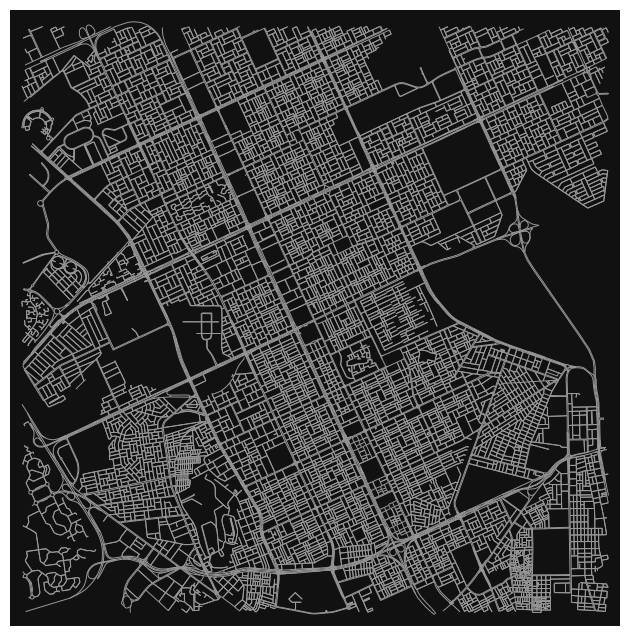

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
ox.plot_graph(G, node_size=0, edge_linewidth=0.7)


### Edge length heatmap-like

<Figure size 1400x1200 with 0 Axes>

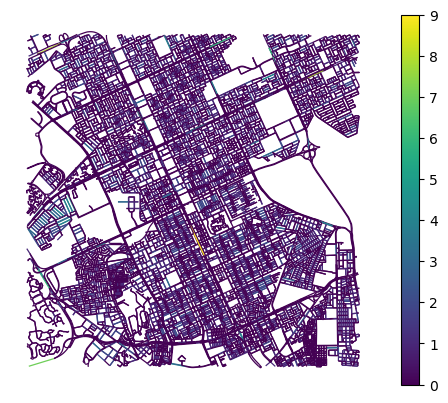

In [6]:
edges2 = edges.copy()
edges2["len_bin_m"] = (edges2["length"] // 100).clip(0, 30)  # 0..3000+ meters

plt.figure(figsize=(14, 12))
ax = edges2.plot(column="len_bin_m", legend=True, linewidth=0.9)
ax.set_axis_off()
plt.show()


### Node density hexbin

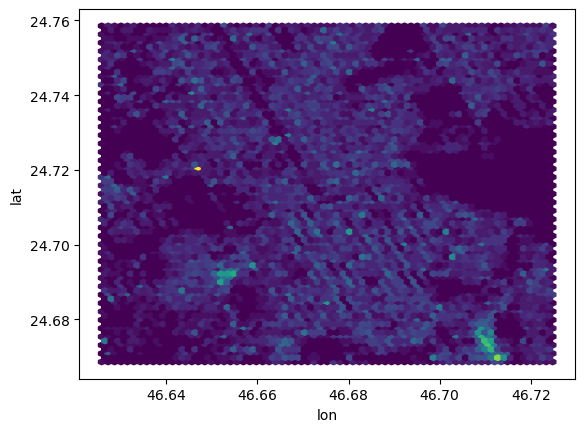

In [7]:
xs = nodes.geometry.x.to_numpy()
ys = nodes.geometry.y.to_numpy()

plt.hexbin(xs, ys, gridsize=70)
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()


### Visualizing road type map

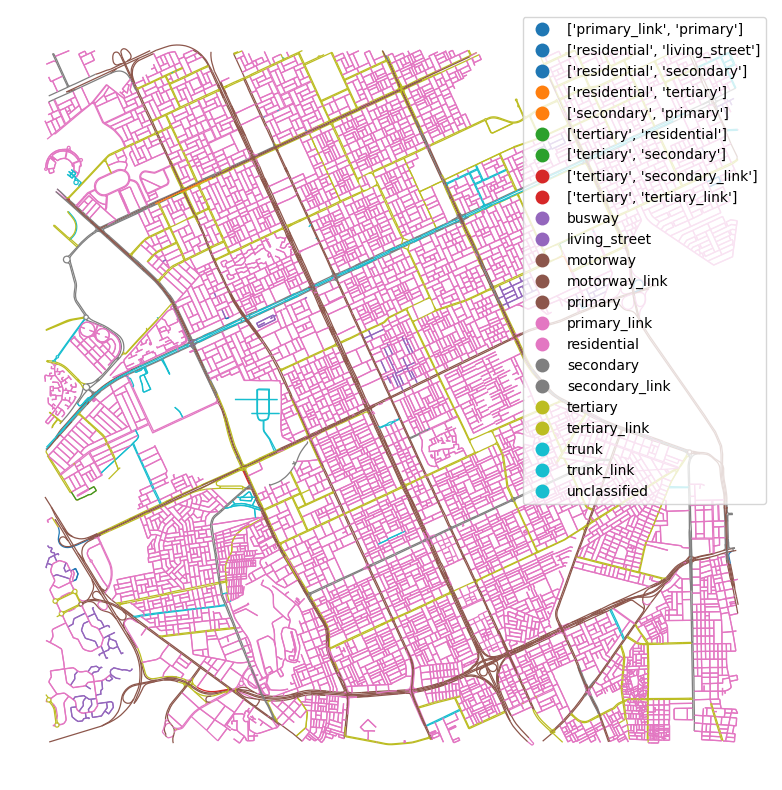

In [8]:
import matplotlib.pyplot as plt

edges3 = edges.copy()
edges3["highway_str"] = edges3["highway"].astype(str)

fig, ax = plt.subplots(figsize=(20, 10))  # increase size here
edges3.plot(column="highway_str", legend=True, linewidth=0.9, ax=ax)

ax.set_axis_off()
plt.show()


### Insights

The road network shows a clear hierarchy: major arterial roads (motorways, primary, trunk) form the main mobility corridors, while residential streets dominate in number and create a dense grid structure.

Road density is highest in the urban core, indicating smaller block sizes, higher intersection frequency, and more intensive land use.

Peripheral areas within the selected boundary have lower road density and longer road segments, suggesting larger land parcels and less compact development.

Short road segments are concentrated in central neighborhoods, while longer segments appear mainly along major corridors designed for faster traffic movement.


# Q3

### Picking two points on a map. 

Al Masmak Fortress (24.6319, 46.7133), 
Al Murabba Palace (24.6469, 46.7101)

In [9]:
import osmnx as ox
import folium

# POIs (lat, lon)
poi1_name, poi1 = "Al Masmak Fortress", (24.631302451541796, 46.71339112466371)
poi2_name, poi2 = "Al Murabba Palace", (24.646561529482184, 46.70911535246266)

# Center the map between the two points
center_lat = (poi1[0] + poi2[0]) / 2
center_lon = (poi1[1] + poi2[1]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

folium.Marker(
    location=[poi1[0], poi1[1]],
    popup=poi1_name,
    tooltip=poi1_name,
    icon=folium.Icon(icon="info-sign")
).add_to(m)

folium.Marker(
    location=[poi2[0], poi2[1]],
    popup=poi2_name,
    tooltip=poi2_name,
    icon=folium.Icon(color="green", icon="info-sign")
).add_to(m)
m


# Q4

### Finding the shortest path between Al Masmak Fortress (24.6319, 46.7133), Al Murabba Palace (24.6469, 46.7101)

In [10]:
# !pip install osmnx
!pip install optalgotools

import osmnx
from optalgotools.structures import Node
from optalgotools.routing import cost, draw_route
from optalgotools.algorithms.graph_search import BFS, DFS, Dijkstra
import pandas as pd
import time, math, random, sys

pd.options.compute.use_numexpr = False


### Defining  POIs

In [11]:
# Riyadh downtown POIs (lat, lon)
source_point = (24.6319, 46.7133)       # Al Masmak Fortress
destination_point = (24.6469, 46.7101)  # Al Murabba area

# midpoint reference
reference_point = (
    (source_point[0] + destination_point[0]) / 2,
    (source_point[1] + destination_point[1]) / 2
)

# graph around midpoint (increase dist as needed)
G = osmnx.graph_from_point(reference_point, dist=2500, simplify=True, network_type="drive")
# Add edge lengths (in meters). some osmnx versions removed add_edge_lengths,
# so compute lengths from geometry when available or haversine between nodes.
import math
def _haversine(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1 = math.radians(lat1); phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1); dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))
for u, v, k, data in G.edges(keys=True, data=True):
    if 'length' in data:
        continue
    if 'geometry' in data and data['geometry'] is not None:
        # geometry.length yields meters for projected geometries; for lat/lon it's in degrees
        try:
            data['length'] = data['geometry'].length
            continue
        except Exception:
            pass
    # fallback: compute haversine distance between node coordinates
    u_n = G.nodes[u]
    v_n = G.nodes[v]
    data['length'] = _haversine(u_n.get('y', u_n.get('lat')), u_n.get('x', u_n.get('lon')), v_n.get('y', v_n.get('lat')), v_n.get('x', v_n.get('lon')))

# nearest nodes
origin_id = osmnx.distance.nearest_nodes(G, source_point[1], source_point[0])
destination_id = osmnx.distance.nearest_nodes(G, destination_point[1], destination_point[0])

# Node objects (demo style)
origin = Node(graph=G, osmid=origin_id)
destination = Node(graph=G, osmid=destination_id)

origin_id, destination_id


(604682705, 3689656676)

BFS

In [12]:
solution_bfs = BFS(origin, destination)
route_bfs = solution_bfs.result

print(f"Cost: {cost(G, route_bfs)} m")
print(f"Process time: {solution_bfs.time} s")
print(f"Space required: {solution_bfs.space} bytes")
print(f"Explored nodes: {solution_bfs.explored}")

draw_route(G, route_bfs)


Cost: 2267.2225 m
Process time: 0.046875 s
Space required: 2872 bytes
Explored nodes: 1772


### DFS

In [13]:
solution_dfs = DFS(origin, destination)
route_dfs = solution_dfs.result

print(f"Cost: {cost(G, route_dfs)} m")
print(f"Process time: {solution_dfs.time} s")
print(f"Space required: {solution_dfs.space} bytes")
print(f"Explored nodes: {solution_dfs.explored}")

draw_route(G, route_dfs)


Cost: 39142.1785 m
Process time: 0.4375 s
Space required: 6040 bytes
Explored nodes: 5821


### Dijkstra

In [14]:
unrelaxed_nodes = [Node(G, osmid) for osmid in G.nodes()]

solution_dij = Dijkstra(origin, destination, unrelaxed_nodes)
route_dij = solution_dij.result

print(f"Cost: {cost(G, route_dij)} m")
print(f"Process time: {solution_dij.time} s")
print(f"Space required: {solution_dij.space} bytes")
print(f"Explored nodes: {solution_dij.explored}")

draw_route(G, route_dij)


Cost: 1977.58 m
Process time: 5.34375 s
Space required: 59736 bytes
Explored nodes: 2101


### Simulated Annealing

In [15]:
def dijkstra_path_ids(G, a, b):
    return osmnx.shortest_path(G, a, b, weight="length")

class SimpleSolution:
    def __init__(self, result, time_s, space_bytes, explored):
        self.result = result
        self.time = time_s
        self.space = space_bytes
        self.explored = explored

def simulated_annealing_route(G, start_id, goal_id, init_route, iters=400, T0=300.0, alpha=0.98, seed=2):
    random.seed(seed)

    t0 = time.perf_counter()

    best = init_route[:]
    best_cost = cost(G, best)

    cur = init_route[:]
    cur_cost = best_cost

    explored = 0
    T = T0

    for _ in range(iters):
        explored += 1

        if len(cur) < 6:
            break

        i = random.randint(2, len(cur) - 3)
        pivot = cur[i]

        try:
            r1 = dijkstra_path_ids(G, start_id, pivot)
            r2 = dijkstra_path_ids(G, pivot, goal_id)
            cand = r1[:-1] + r2
        except Exception:
            T *= alpha
            continue

        cand_cost = cost(G, cand)
        delta = cand_cost - cur_cost

        if delta < 0 or random.random() < math.exp(-delta / max(T, 1e-9)):
            cur, cur_cost = cand, cand_cost
            if cur_cost < best_cost:
                best, best_cost = cur[:], cur_cost

        T *= alpha

    t1 = time.perf_counter()
    space_bytes = sys.getsizeof(best)

    return SimpleSolution(best, t1 - t0, space_bytes, explored)

solution_sa = simulated_annealing_route(G, origin_id, destination_id, route_dij, iters=500, T0=400.0, alpha=0.985, seed=2)
route_sa = solution_sa.result

print(f"Cost: {cost(G, route_sa)} m")
print(f"Process time: {solution_sa.time} s")
print(f"Space required: {solution_sa.space} bytes")
print(f"Explored nodes: {solution_sa.explored}")

draw_route(G, route_sa)


Cost: 1977.58 m
Process time: 54.835514699982014 s
Space required: 328 bytes
Explored nodes: 500


## Performance Comparison of the four Algorithms

In [ ]:
results = pd.DataFrame([
    {"Algorithm": "BFS", "Time (s)": solution_bfs.time, "Cost (m)": cost(G, route_bfs)},
    {"Algorithm": "DFS", "Time (s)": solution_dfs.time, "Cost (m)": cost(G, route_dfs)},
    {"Algorithm": "Dijkstra", "Time (s)": solution_dij.time, "Cost (m)": cost(G, route_dij)},
    {"Algorithm": "SA", "Time (s)": solution_sa.time, "Cost (m)": cost(G, route_sa)},
]).sort_values("Cost (m)")

results


,Algorithm,Time (s),Cost (m)
2,Dijkstra,5.343750,1977.5800
3,Simulated Annealing,54.835515,1977.5800
0,BFS,0.046875,2267.2225
1,DFS,0.437500,39142.1785
